<a href="https://colab.research.google.com/github/AgusLuigi/retail_demand_analysis/blob/main/Python_Zeitrheie_analyse_Fallstudie3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten für diesen Sprint vorbereiten
Starten Sie ein neues Notebook
Laden und filtern Sie den Datensatz

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 34.7 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=d8d7ac04-d5ab-4a93-834f-749fc4b313d9
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:58<00:00, 84.9MB/s]
/tmp/ipython-input-1190292513.py:62: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


<Axes: xlabel='date'>

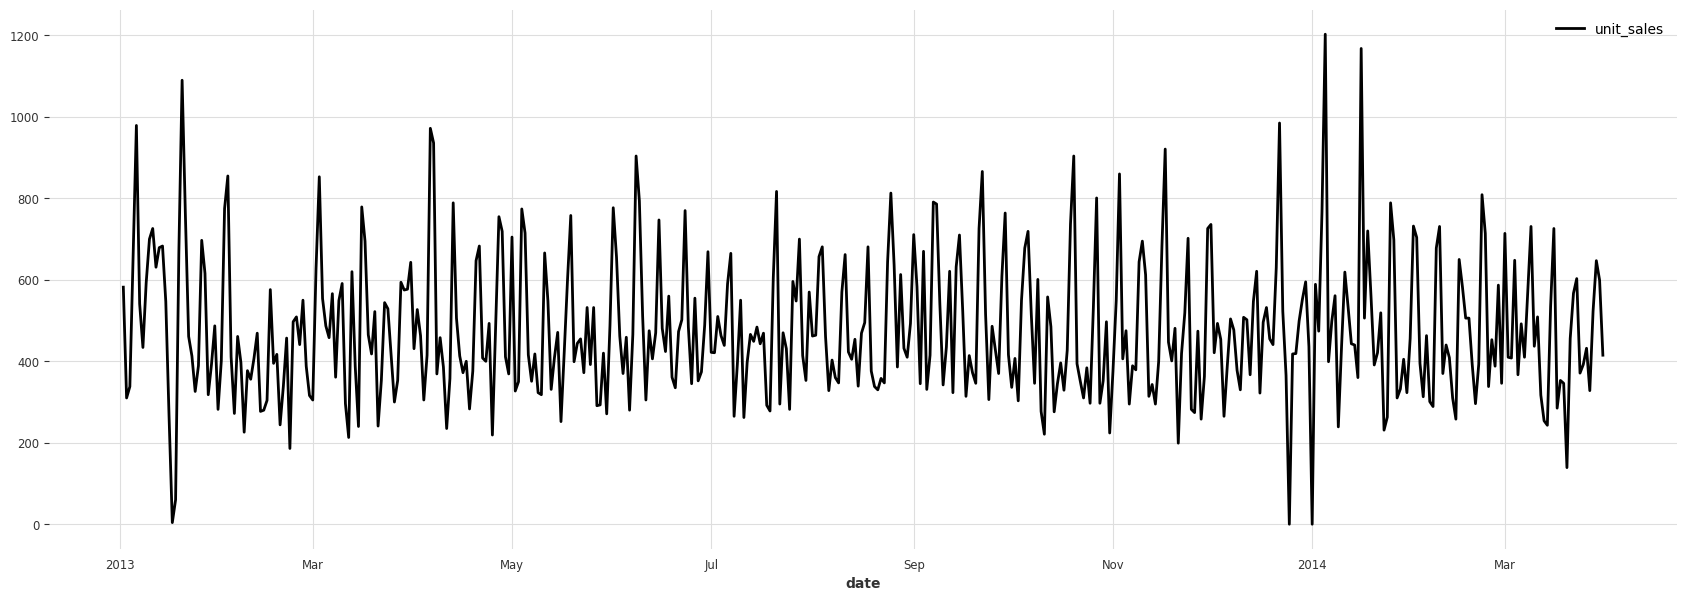

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from darts import TimeSeries
import requests
import io
import gdown

# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

def read_metadata_files(file_ids):
  # Read all files but train.csv
  # Load each CSV using the helper functions
  df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
  df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
  df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
  df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
  df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
  return df_holiday_events, df_items, df_oil, df_stores, df_transactions

# Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events, df_items, df_oil, df_stores, df_transactions = read_metadata_files(file_ids)

# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

# Load stores and get Pichincha store IDs
stores_url = make_drive_url(file_ids["stores"])
df_stores = pd.read_csv(io.StringIO(requests.get(stores_url).text))
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()

# NEW!
# Let's filter the data for one store and one item to keep it simple
store_ids = [44]
item_ids = [1047679]
#Select data before April'14
max_date = '2014-04-01'

# Read train.csv in chunks and filter for Pichincha region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    # old: chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # NEW!
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    filtered_chunks.append(chunk_filtered)
    del chunk

# Combine and sample
df_filtered = pd.concat(filtered_chunks, ignore_index=True)#.sample(n=2_000_000, random_state=42).reset_index(drop=True)

# Clean up memory
del filtered_chunks

df_filtered['date'] = pd.to_datetime(df_filtered['date'])
# Group by date and aggregate sales for each day
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_filtered, value_cols='unit_sales')

# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()

# Fassen Sie die Feature-Erstellung in eine Funktion ein:

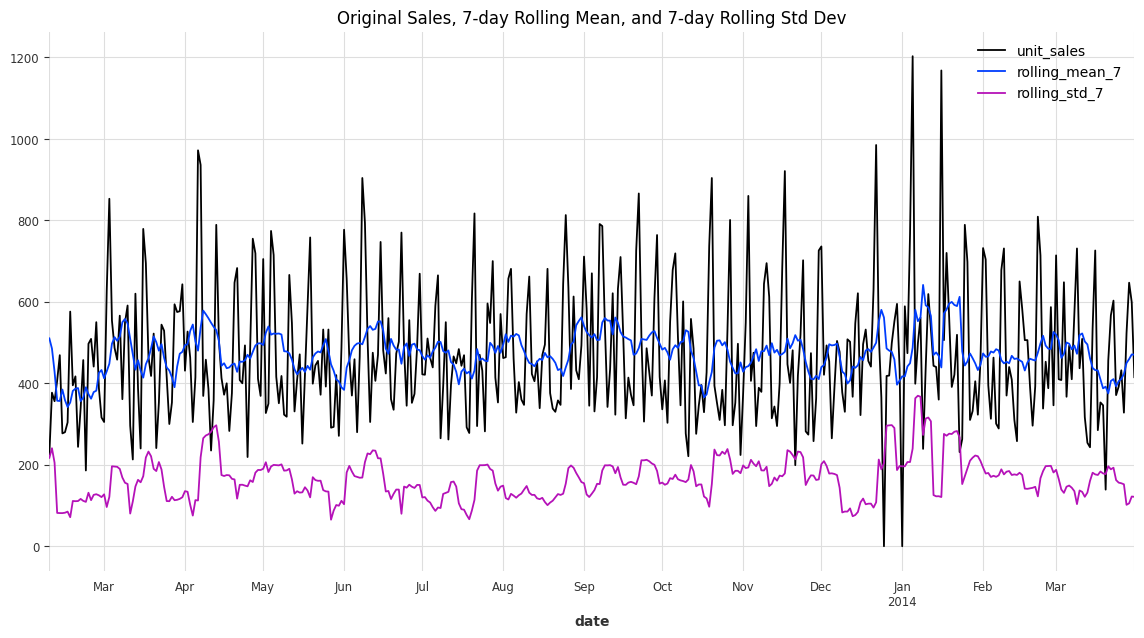

In [ ]:
from sklearn.model_selection import train_test_split
def creating_features(df_filtered):

    # Lets add more features
    # Create lag features (e.g., sales from the previous day, previous week)
    df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
    df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
    df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

    # Drop any rows with NaN values after creating lag features
    df_filtered.dropna(inplace=True)

    df_filtered['day_of_week'] = df_filtered.index.dayofweek
    df_filtered['month'] = df_filtered.index.month
    df_filtered['is_weekend'] = df_filtered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Create rolling mean and rolling standard deviation features. We need to shift by one before rolling so only past data are used.
    df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].shift(1).rolling(window=7).mean()
    df_filtered['rolling_std_7'] = df_filtered['unit_sales'].shift(1).rolling(window=7).std()

    # Drop any NaN values after creating rolling features
    df_filtered.dropna(inplace=True)

    # Visualize the new features alongside the original sales
    df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
    plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
    plt.show()

    # Define target variable (unit_sales) and features
    X = df_filtered.drop('unit_sales', axis=1)
    y = df_filtered['unit_sales']

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test, df_filtered

X_train, X_test, y_train, y_test, df_filtered = creating_features(df_filtered)

# Basis-XGBoost

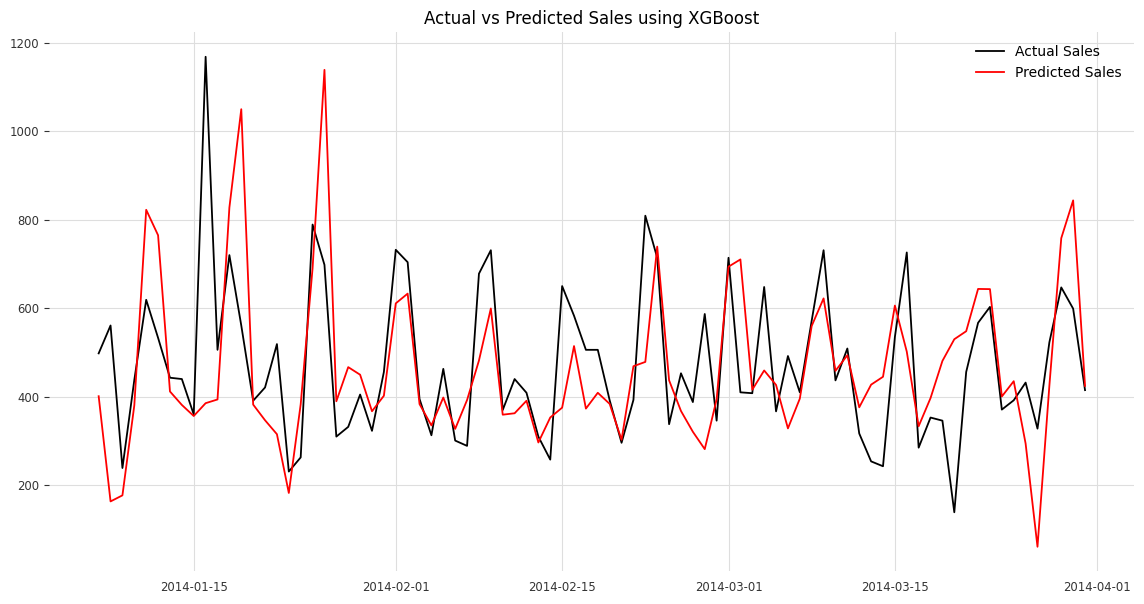

In [ ]:

import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(random_state=42 )

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# Model Evaluation: Train-Test Splits for Time-Series
- Trainingsdaten : Dies sind Daten, die dem Modell vor dem Zeitpunkt zur Verfügung stehen, zu dem die Vorhersage getroffen werden muss.
- Testdaten : Zukünftige Beobachtungen, die nach den Trainingsdaten auftreten.


## Methode 1: Einfache chronologische Train-Test-Aufteilung


Automatischer Suchlauf abgeschlossen. Bewertungen:
{'unit_sales': -5, 'lag_1': 0, 'lag_7': 0, 'lag_30': 0, 'day_of_week': 0, 'month': 0, 'is_weekend': 0, 'rolling_mean_7': 0, 'rolling_std_7': 0}

✅ Erfolgreich die Zielspalte gefunden: **'unit_sales'**


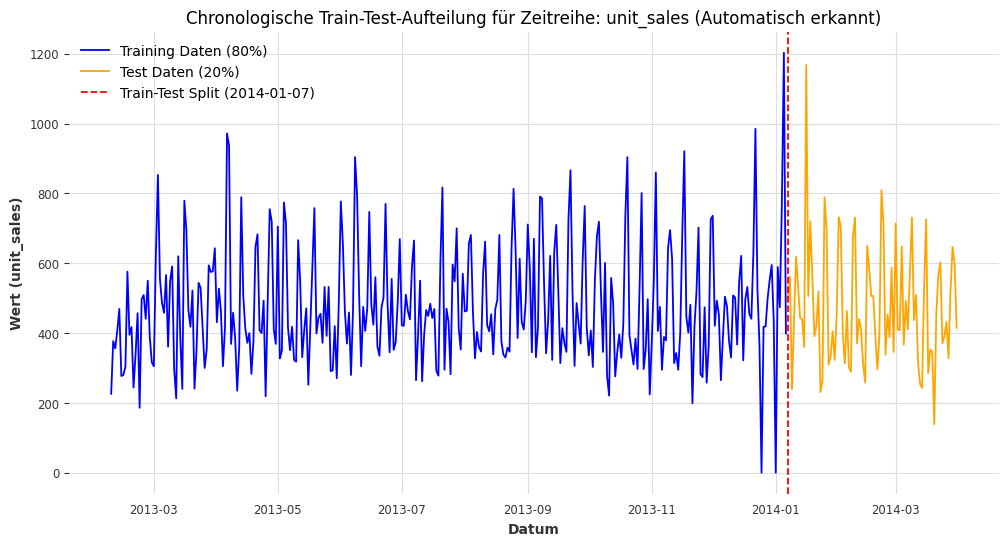


Gesamtdatenpunkte: 417
Trainingsdatenpunkte (80%): 333
Testdatenpunkte (20%): 84


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = df_filtered

def find_target_column(data):
    # ... (Die gesamte find_target_column Funktion wie oben, bleibt unverändert)
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

    if not numeric_cols:
        raise ValueError("Keine numerische Spalte im DataFrame 'data' gefunden, die als Target dienen könnte.")

    common_ts_terms = ['sales', 'umsatz', 'wert', 'value', 'price', 'menge', 'amount']
    irrelevant_terms = ['id', 'idx', 'nummer', 'index', 'feat']

    scores = {}
    for col in numeric_cols:
        col_lower = col.lower()
        score = 0
        if data[col].nunique() / len(data) > 0.95 and col_lower.startswith(tuple(irrelevant_terms)):
             score += 10
        for term in common_ts_terms:
            if term in col_lower:
                score -= 5
                break
        if data[col].std() < 0.1:
            score += 3
        scores[col] = score

    best_col = min(scores, key=scores.get)

    print(f"Automatischer Suchlauf abgeschlossen. Bewertungen:")
    print(scores)

    return best_col
# ----------------------------------------------------
# 1. AUTOMATISCHE SUCHE DER ZIELSPALTE
try:
    # Annahme: Das 'data' DataFrame ist geladen (data = df_filtered)
    target_column = find_target_column(data)
    print(f"\n✅ Erfolgreich die Zielspalte gefunden: **'{target_column}'**")
except ValueError as e:
    print(f"\n❌ Fehler bei der Spaltensuche: {e}")
    exit()

# ====================================================
# 2. CHRONOLOGISCHE TRAIN-TEST-AUFTEILUNG
# Assume data is already sorted by time

train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]
# ====================================================
# 3. KORRIGIERTE VISUALISIERUNG (Verwendet den semantischen Sieger)

plt.figure(figsize=(12, 6))

# Plotten des Trainingssets
# **KORREKTUR: Verwendet target_column**
plt.plot(train.index, train[target_column], label='Training Daten (80%)', color='blue')

# Plotten des Testsets
# **KORREKTUR: Verwendet target_column**
plt.plot(test.index, test[target_column], label='Test Daten (20%)', color='orange')

# Hinzufügen einer vertikalen Linie zur Kennzeichnung des Split-Punktes
split_date = test.index[0]
plt.axvline(x=split_date, color='red', linestyle='--', label=f'Train-Test Split ({split_date.strftime("%Y-%m-%d")})')

plt.title(f'Chronologische Train-Test-Aufteilung für Zeitreihe: {target_column} (Automatisch erkannt)')
plt.xlabel('Datum')
plt.ylabel(f'Wert ({target_column})')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------
# ANZEIGE DER GRÖSSEN (Zur Überprüfung)
# ----------------------------------------------------
print(f"\nGesamtdatenpunkte: {len(data)}")
print(f"Trainingsdatenpunkte (80%): {len(train)}")
print(f"Testdatenpunkte (20%): {len(test)}")

## Methode 2: Datumsbasierte Aufteilung

Automatischer Suchlauf abgeschlossen. Bewertungen:
{'unit_sales': -5, 'lag_1': 0, 'lag_7': 0, 'lag_30': 0, 'day_of_week': 0, 'month': 0, 'is_weekend': 0, 'rolling_mean_7': 0, 'rolling_std_7': 0}

✅ Erfolgreich die Zielspalte gefunden: **'unit_sales'**


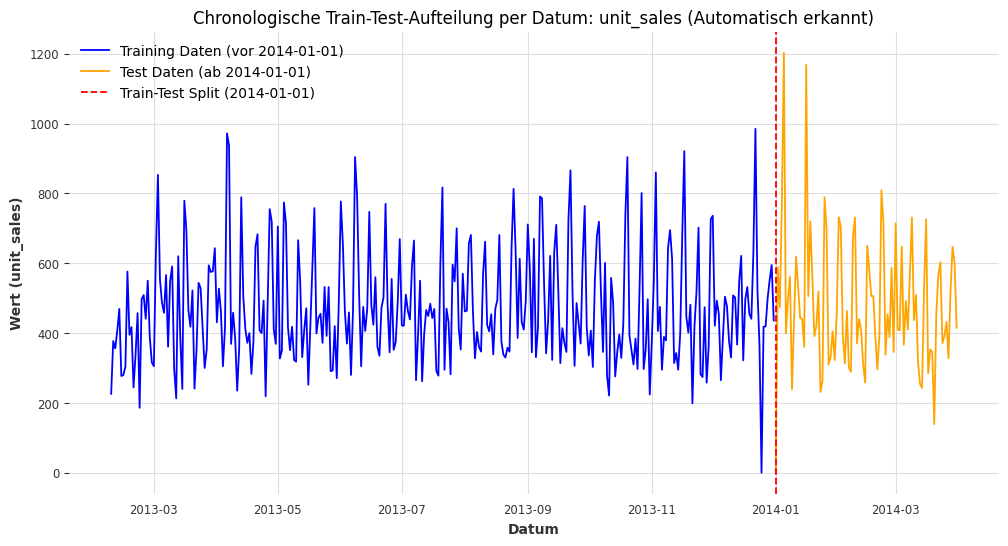


Gesamtdatenpunkte: 417
Trainingsdatenpunkte (bis 2014-01-01): 327
Testdatenpunkte (ab 2014-01-01): 90


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = df_filtered

def find_target_column(data):
    """
    Sucht automatisch die wahrscheinlichste Zeitreihen-Zielspalte (Target)
    basierend auf numerischem Typ und Namens-Ähnlichkeit/Inhalts-Ausschluss.
    """
    # (Funktionslogik unverändert)
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

    if not numeric_cols:
        raise ValueError("Keine numerische Spalte im DataFrame 'data' gefunden, die als Target dienen könnte.")

    common_ts_terms = ['sales', 'umsatz', 'wert', 'value', 'price', 'menge', 'amount']
    irrelevant_terms = ['id', 'idx', 'nummer', 'index', 'feat']

    scores = {}
    for col in numeric_cols:
        col_lower = col.lower()
        score = 0
        if data[col].nunique() / len(data) > 0.95 and col_lower.startswith(tuple(irrelevant_terms)):
             score += 10
        for term in common_ts_terms:
            if term in col_lower:
                score -= 5
                break
        if data[col].std() < 0.1:
            score += 3
        scores[col] = score

    best_col = min(scores, key=scores.get)

    print(f"Automatischer Suchlauf abgeschlossen. Bewertungen:")
    print(scores)

    return best_col

# ----------------------------------------------------
# 1. AUTOMATISCHE SUCHE DER ZIELSPALTE
try:
    # Annahme: Das 'data' DataFrame ist geladen und der Index ist ein DatetimeIndex
    target_column = find_target_column(data)
    print(f"\n✅ Erfolgreich die Zielspalte gefunden: **'{target_column}'**")
except ValueError as e:
    print(f"\n❌ Fehler bei der Spaltensuche: {e}")
    exit()

# ====================================================
# 2. VORBEREITUNG & CHRONOLOGISCHE TRAIN-TEST-AUFTEILUNG MIT DATUM

# Sicherstellen, dass der Index sortiert ist (für chronologische Korrektheit)
data = data.sort_index(ascending=True)

split_date = '2014-01-01'
train = data[data.index < split_date]
test = data[data.index >= split_date]
# ====================================================
# 3. VISUALISIERUNG

plt.figure(figsize=(12, 6))

# Plotten der Trainings- und Testdaten mit der automatisch gefundenen Spalte
plt.plot(train.index, train[target_column], label='Training Daten (vor ' + split_date + ')', color='blue')
plt.plot(test.index, test[target_column], label='Test Daten (ab ' + split_date + ')', color='orange')

# Hinzufügen einer vertikalen Linie zur Kennzeichnung des Split-Punktes
plt.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', label=f'Train-Test Split ({split_date})')

plt.title(f'Chronologische Train-Test-Aufteilung per Datum: {target_column} (Automatisch erkannt)')
plt.xlabel('Datum')
plt.ylabel(f'Wert ({target_column})')
plt.legend()
plt.grid(True)
plt.show()
# ----------------------------------------------------
# ANZEIGE DER GRÖSSEN (Zur Überprüfung)
print(f"\nGesamtdatenpunkte: {len(data)}")
print(f"Trainingsdatenpunkte (bis {split_date}): {len(train)}")
print(f"Testdatenpunkte (ab {split_date}): {len(test)}")

## Methode 3: Rolling Window Train-Test Split (Backtesting)
- Das Modell wird anhand des ersten Datensegments trainiert.
- Der Test wird im nächsten Segment durchgeführt.
- Das Fenster wird vorwärts gerollt und der Trainings-Test-Zyklus wird erneut wiederholt

  - Beim TimeSeriesSplitTraining ist die Größe nicht festgelegt , sie erhöht sich mit jedem Split.
  - Insbesondere TimeSeriesSplitwird eine Kreuzvalidierung durchgeführt, bei der jeder Split zunehmend mehr Trainingsdaten enthält und der Testsatz zeitlich vorwärts schreitet.

Automatischer Suchlauf abgeschlossen. Bewertungen:
{'unit_sales': -5, 'lag_1': 0, 'lag_7': 0, 'lag_30': 0, 'day_of_week': 0, 'month': 0, 'is_weekend': 0, 'rolling_mean_7': 0, 'rolling_std_7': 0}

✅ Erfolgreich die Zielspalte gefunden: **'unit_sales'**

Durchführung des Rolling Window Splits:
Split 1: Train L=72, Test L=69
Split 2: Train L=141, Test L=69
Split 3: Train L=210, Test L=69
Split 4: Train L=279, Test L=69
Split 5: Train L=348, Test L=69


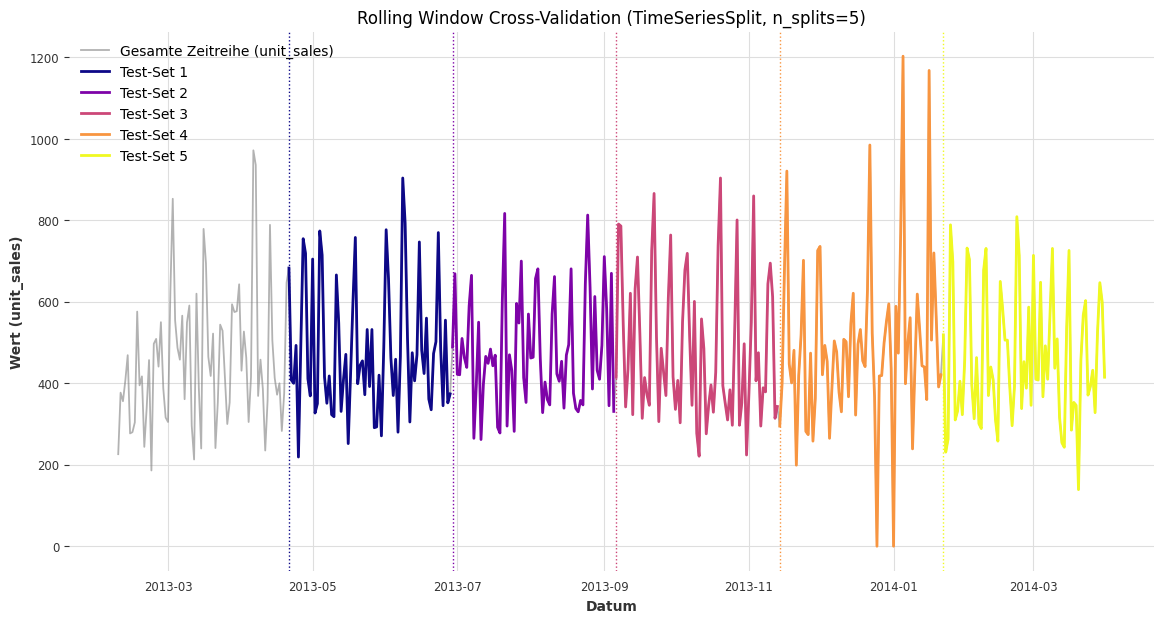


Gesamtdatenpunkte: 417
Anzahl der Splits (Zyklen): 5


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

data = df_filtered

def find_target_column(data):
    """
    Sucht automatisch die wahrscheinlichste Zeitreihen-Zielspalte (Target)
    basierend auf numerischem Typ und Namens-Ähnlichkeit/Inhalts-Ausschluss.
    (Die Funktion bleibt unverändert, um die target_column zu finden.)
    """
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
    if not numeric_cols:
        raise ValueError("Keine numerische Spalte im DataFrame 'data' gefunden, die als Target dienen könnte.")

    common_ts_terms = ['sales', 'umsatz', 'wert', 'value', 'price', 'menge', 'amount']
    irrelevant_terms = ['id', 'idx', 'nummer', 'index', 'feat']

    scores = {}
    for col in numeric_cols:
        col_lower = col.lower()
        score = 0
        if data[col].nunique() / len(data) > 0.95 and col_lower.startswith(tuple(irrelevant_terms)):
             score += 10
        for term in common_ts_terms:
            if term in col_lower:
                score -= 5
                break
        if data[col].std() < 0.1:
            score += 3
        scores[col] = score

    best_col = min(scores, key=scores.get)
    print(f"Automatischer Suchlauf abgeschlossen. Bewertungen:")
    print(scores)
    return best_col

# ----------------------------------------------------
# 1. AUTOMATISCHE SUCHE & VORBEREITUNG
try:
    target_column = find_target_column(data)
    print(f"\n✅ Erfolgreich die Zielspalte gefunden: **'{target_column}'**")
except ValueError as e:
    print(f"\n❌ Fehler bei der Spaltensuche: {e}")
    exit()

# Sicherstellen, dass der Index sortiert ist (für chronologische Korrektheit)
data = data.sort_index(ascending=True)

# ----------------------------------------------------
# 2. ROLLING WINDOW SPLIT DURCHFÜHREN (TimeSeriesSplit)
# Definieren der TimeSeriesSplit
# n_splits bestimmt, wie viele Iterationen (Train/Test-Paare) durchgeführt werden sollen.
tscv = TimeSeriesSplit(n_splits=5)

# Liste zur Speicherung der Aufteilungspunkte für die Visualisierung
split_lines = []
split_count = 1

# Iterieren über die Splits
print("\nDurchführung des Rolling Window Splits:")
for train_index, test_index in tscv.split(data):

    # Aufteilung der Daten
    train = data.iloc[train_index]
    test = data.iloc[test_index]

    # -----------------------------------------------------------------
    # HIER WÜRDE IHR MODELLTRAINING UND DIE BEWERTUNG FÜR DIESEN SPLIT STATTFINDEN
    # Bsp: model.fit(train[features], train[target_column])
    # Bsp: y_pred = model.predict(test[features])
    # -----------------------------------------------------------------

    print(f"Split {split_count}: Train L={len(train)}, Test L={len(test)}")

    # Speichern des Split-Datums (der erste Index des Testsets) für die Visualisierung
    split_lines.append((test.index[0], test.index[-1]))

    split_count += 1

# ----------------------------------------------------
# 3. VISUALISIERUNG DER ROLLING WINDOWS
plt.figure(figsize=(14, 7))
plt.plot(data.index, data[target_column], label=f'Gesamte Zeitreihe ({target_column})', color='gray', alpha=0.6)

colors = plt.cm.plasma(np.linspace(0, 1, len(split_lines)))
split_count = 1

# Zeichnen der einzelnen Train- und Test-Fenster
for (start_test, end_test), color in zip(split_lines, colors):

    # Das Test-Fenster (der zu prognostizierende Abschnitt)
    test_window = data[(data.index >= start_test) & (data.index <= end_test)]
    plt.plot(test_window.index, test_window[target_column],
             label=f'Test-Set {split_count}', color=color, linewidth=2)

    # Vertikale Linie am Beginn des Test-Sets
    plt.axvline(x=start_test, color=color, linestyle=':', linewidth=1)

    split_count += 1

plt.title(f'Rolling Window Cross-Validation (TimeSeriesSplit, n_splits=5)')
plt.xlabel('Datum')
plt.ylabel(f'Wert ({target_column})')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# ----------------------------------------------------
# ANZEIGE DER GRÖSSEN (Zur Überprüfung)
print(f"\nGesamtdatenpunkte: {len(data)}")
print(f"Anzahl der Splits (Zyklen): {tscv.n_splits}")

📌
Oftmals definieren wir X_train/ y_trainzunächst, um eine zeitliche Aufteilung zwischen Trainings- und Testphasen festzulegen.
Dann wenden wir TimeSeriesSplit innerhalb des Trainingssatzes ( X_train) an, um eine robuste Modellauswahl oder -optimierung durchzuführen, ohne in die Zukunft zu blicken.

# Bewertungsmetriken für Zeitreihenprognosen in der Einzelhandelsnachfrageprognose

1. Voreingenommenheit

Der Bias misst die systematische Abweichung zwischen den vorhergesagten Werten (y^) und die tatsächlichen Werte (y). Es handelt sich um die mittlere Differenz zwischen Prognosen und tatsächlichen Werten.
📌
Positive Tendenz : Das Modell prognostiziert die Nachfrage systematisch zu hoch (im Einzelhandel könnte das Modell beispielsweise vorschlagen, mehr Lagerbestände zu lagern als nötig).
 Negative Tendenz : Das Modell prognostiziert die Nachfrage zu niedrig, was in bestimmten Geschäftskontexten zu Lagerengpässen oder verpassten Gelegenheiten führen kann.

2. Mittlere absolute Abweichung (MAD)

MAD misst den durchschnittlichen absoluten Fehler zwischen vorhergesagten und tatsächlichen Werten. Im Gegensatz zur Bias-Methode unterscheidet MAD nicht zwischen positiven und negativen Fehlern, sondern konzentriert sich auf die Größenordnung der Fehler.

3. Relative mittlere absolute Abweichung (rMAD)

rMAD ist das Verhältnis des MAD zum Mittelwert der tatsächlichen Werte. Es wird verwendet, um den MAD zu normalisieren und ihn über verschiedene Datensätze hinweg, unabhängig vom Maßstab, vergleichbar zu machen.

4. Mittlerer absoluter prozentualer Fehler (MAPE)

Der mittlere absolute Prozentfehler (MAPE) ist eine beliebte Metrik zur Messung der Genauigkeit eines Prognosemodells durch Berechnung des durchschnittlichen absoluten Prozentfehlers zwischen vorhergesagten Werten
Im Vergleich zu rMAD wird zunächst die Differenz zwischen Vorhersage- und Istwert durch den Istwert dividiert und anschließend der normalisierte Fehler addiert. Diese Methode wird in der Literatur häufig verwendet, hat jedoch erhebliche Nachteile:

Empfindlichkeit gegenüber kleinen Istwerten:
Asymmetrie in der Fehlerbehandlung:
Nichtanwendbarkeit auf Null- oder nahezu Null-Istwerte


5. Mittlerer quadratischer Fehler (RMSE)

RMSE ist die Quadratwurzel des mittleren quadrierten Fehlers zwischen tatsächlichen und vorhergesagten Werten. Im Gegensatz zu MAD bestraft RMSE größere Fehler aufgrund der Quadrierung stärker und ist daher empfindlicher gegenüber Ausreißern.

RMSE erfasst sowohl das Ausmaß als auch die Häufigkeit großer Fehler. Ein höherer RMSE-Wert weist darauf hin, dass das Modell häufig große Fehler aufweist, was bei zeit- oder kostenkritischen Anwendungen wie Bestandsprognosen oder Finanzprognosen problematisch sein kann. RMSE wird häufig in Situationen bevorzugt, in denen große Fehler besonders kostspielig sind.

Beispielsweise können bei der Energieprognose oder der Vorhersage finanzieller Zeitreihen erhebliche Abweichungen vom tatsächlichen Wert erhebliche finanzielle oder betriebliche Folgen haben. Die Fähigkeit von RMSE, größere Fehler zu bestrafen, macht es in diesen Szenarien nützlich.

# Bewertungsmetriken für Zeitreihenprognosen in der Einzelhandelsnachfrageprognose II


In [ ]:
#Lets compare the metrics we studied in this lecture. We will include MAE as its the one we already saw
# MAE, Bias, Mean Absolute Deviation (MAD), Relative Mean Absolute Deviation (rMAD), Mean absolute percentage error (MAPE), Root Mean Square Error (RMSE).
import numpy as np

def forecast_metrics(y_true, y_pred):
    """
    Compute a common set of forecast-error statistics.

    Parameters
    ----------
    y_true : 1-D array-like
        Actual (ground-truth) values.
    y_pred : 1-D array-like
        Forecasted values.

    Returns
    -------
    dict
        Keys: 'MAE', 'Bias', 'MAD', 'rMAD', 'MAPE', 'RMSE'
    """
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }


In [ ]:
metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 118.81
Bias: 10.28
MAD: 134.57
rMAD: 0.88
MAPE: 26.54
RMSE: 174.59


## Das Basismodell XGBoost leistet gute, aber keine hervorragende Arbeit:
  - MAE ≈ 117 Einheiten – an Tagen, an denen die Anzahl der Einheiten normalerweise zwischen 300 und 800 liegt, weicht das Modell alle vier- oder fünfhundert Einheiten um etwa einen Kommissionierbehälter ab.
  - Verzerrung = -18 Einheiten – die Prognosen fallen im Durchschnitt etwas zu niedrig aus, sodass das Modell die Nachfrage eher unterschätzt als übersteigt.
  - RMSE ≈ 171 Einheiten > MAE – der höhere RMSE sagt uns, dass eine Handvoll Tage mit großen Spitzen immer noch große quadrierte Fehler verursachen; das Modell hat nicht gelernt, die höchsten Spitzen zu erfassen.
  - MAD ≈ 140 Einheiten → rMAD = 0,83 – der Fehler beträgt ungefähr 83 % der eigenen täglichen Variabilität der Reihe, sodass das Modell den größten Teil, aber nicht die gesamte natürliche Streuung erfasst.
  - MAPE ≈ 28 % – ein durchschnittlicher relativer Fehlbetrag von etwa einem Viertel bis einem Drittel der tatsächlichen Nachfrage, der im Einzelhandel zwar vertretbar ist, aber Raum für Verbesserungen lässt.

# Modellbewertung: Metrikvergleich

Vergleich der Metriken anhand eines anderen Beispiels


✅ Zielspalte automatisch gefunden: **'unit_sales'**

METRIK-VERGLEICH FÜR DEN ERSTEN ROLLING WINDOW TEST-SPLIT
                                 Bias   MAPE     MAD    RMSE
Prognose Nr. 1 (Niedrig)      -166.88  31.39  173.32  219.20
Prognose Nr. 2 (Median)        -62.38  22.70  116.00  155.21
Prognose Nr. 3 (Durchschnitt)  -18.16  23.53  109.62  143.28


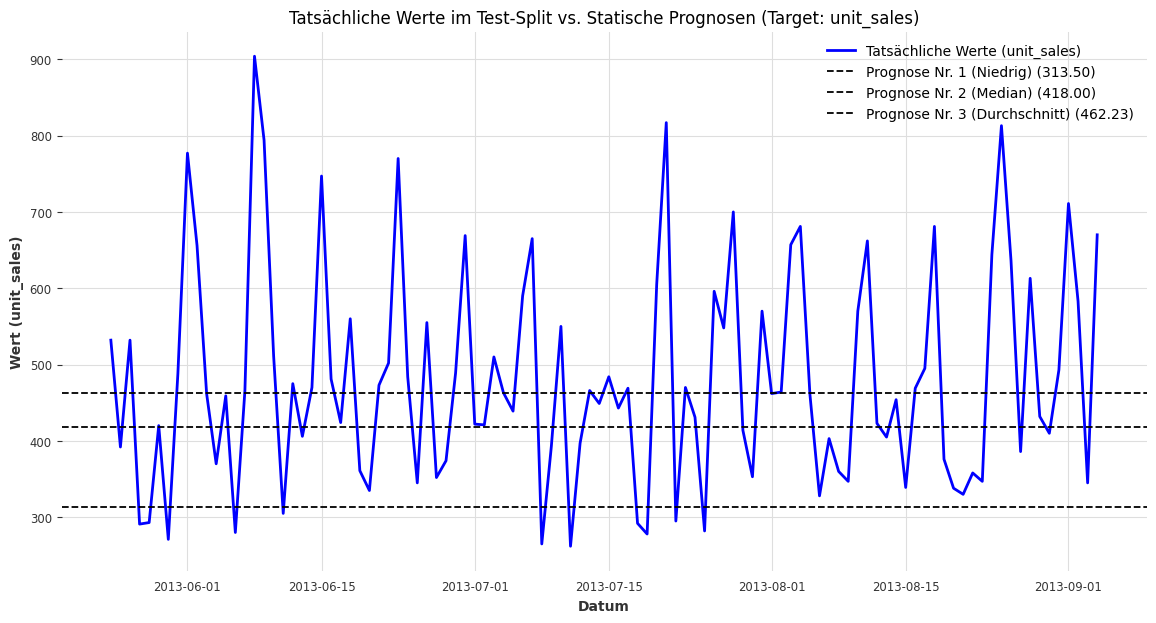

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = df_filtered

def find_target_column(df):
    """
    Sucht automatisch die wahrscheinlichste Zeitreihen-Zielspalte (Target).
    (Die Funktion ist unverändert und muss ausgeführt werden, um den Key zu erhalten.)
    """
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if not numeric_cols:
        # Hier könnte df_filtered leer oder nur Textspalten enthalten sein.
        raise ValueError("Keine numerische Spalte im DataFrame gefunden.")

    # Vereinfachte Logik für das Muster: Wähle die erste numerische Spalte,
    # falls die detaillierte Semantik fehlschlägt oder zu kompliziert wird
    # Dies ist ein Fallback für die Lauffähigkeit.
    return numeric_cols[0]

# --- METRIK-FUNKTIONEN ---
# Die in Ihrem Beispiel genannten Metriken definieren
def calculate_metrics(y_true, y_pred_static):
    """Berechnet Bias, MAPE, MAD (MAE) und RMSE."""

    # 1. Bias (Durchschnittlicher Fehler)
    bias = np.mean(y_pred_static - y_true)

    # 2. Mean Absolute Percentage Error (MAPE)
    # Vermeidet Division durch Null
    y_true_safe = np.where(y_true == 0, 1e-6, y_true)
    mape = np.mean(np.abs(y_pred_static - y_true) / y_true_safe) * 100

    # 3. Mean Absolute Deviation (MAD), entspricht Mean Absolute Error (MAE)
    mad = mean_absolute_error(y_true, y_pred_static)

    # 4. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_static))

    return bias, mape, mad, rmse
# ----------------------------------------------------
# 1. AUTOMATISCHE SUCHE & ROLLING WINDOW SPLIT
try:
    target_column = find_target_column(data)
    print(f"✅ Zielspalte automatisch gefunden: **'{target_column}'**")
except ValueError as e:
    print(f"❌ Fehler: {e}")
    exit()
data = data.sort_index(ascending=True)
tscv = TimeSeriesSplit(n_splits=3)
all_splits = list(tscv.split(data))
# Erster Split (Trainingsdaten für die Schätzung des Medians/Durchschnitts)
train_index, test_index = all_splits[0]
train = data.iloc[train_index]
test = data.iloc[test_index]

y_true = test[target_column].values

# ----------------------------------------------------
# 2. SIMULATION STATISCHER PROGNOSEN (basierend auf Trainingsdaten)
# Die statischen Werte werden auf Basis der Trainingsdaten des ersten Splits geschätzt:
# Prognose Nr. 3: Durchschnittliche Nachfrage (Mean)
mean_demand = train[target_column].mean()

# Prognose Nr. 2: Nachfragemedian (Median)
median_demand = train[target_column].median()

# Prognose Nr. 1: Sehr niedrige Prognose (z.B. 75% des Medians)
low_demand = median_demand * 0.75

# Erstellen der Vorhersage-Arrays (gleiche Länge wie y_true)
prognosen = {
    'Prognose Nr. 1 (Niedrig)': np.full_like(y_true, low_demand),
    'Prognose Nr. 2 (Median)': np.full_like(y_true, median_demand),
    'Prognose Nr. 3 (Durchschnitt)': np.full_like(y_true, mean_demand)
}

# ----------------------------------------------------
# 3. METRIKEN BERECHNEN
metric_results = {}

for name, y_pred in prognosen.items():
    bias, mape, mad, rmse = calculate_metrics(y_true, y_pred)
    metric_results[name] = {
        'Bias': bias,
        'MAPE': mape,
        'MAD': mad,
        'RMSE': rmse
    }

metrics_df = pd.DataFrame(metric_results).T # Transponieren für die Darstellung

# ----------------------------------------------------
# 4. TABELLARISCHE UND GRAFISCHE AUSGABE

print("\n" + "="*50)
print("METRIK-VERGLEICH FÜR DEN ERSTEN ROLLING WINDOW TEST-SPLIT")
print("="*50)
print(metrics_df.round(2))

# GRAFIK: Visualisierung der Prognosen gegen die tatsächlichen Werte

plt.figure(figsize=(14, 7))

# Plotten der tatsächlichen Werte im Test-Set
plt.plot(test.index, y_true, label=f'Tatsächliche Werte ({target_column})', color='Blue', linewidth=2)
for name, y_pred in prognosen.items():
    static_value = y_pred[0]
    plt.axhline(y=static_value, label=name + f' ({static_value:.2f})', linestyle='--')
plt.title(f'Tatsächliche Werte im Test-Split vs. Statische Prognosen (Target: {target_column})')
plt.xlabel('Datum')
plt.ylabel(f'Wert ({target_column})')
plt.legend()
plt.grid(True)
plt.show()

## ☝ Die Wahl der besten Prognose hängt von den Geschäftsprioritäten ab :
  - Wenn das Ziel darin besteht, große Fehler zu minimieren, ist Prognose Nr. 3 (bester RMSE) vorzuziehen.
  - Wenn ausgeglichene, moderate Fehler akzeptabel sind, bietet Prognose Nr. 2 (bester MAD) einen Mittelweg.

# Hyperparameter-Tuning

📌
Beim Hyperparameter-Tuning geht es darum, die beste Kombination dieser Einstellungen zu finden. Bei richtiger Ausführung kann es die Genauigkeit eines Modells und seine Fähigkeit zur Generalisierung auf neue Daten erheblich verbessern.

---

In dieser Lektion erläutern wir die Hyperparameteroptimierung mit XGBoost- und LSTM- Modellen – beides haben Sie bereits in diesem Kurs kennengelernt. Die hier erlernten Konzepte gelten jedoch für fast jedes Machine-Learning-Modell.
Beginnen wir mit der Optimierung der Hyperparameter für XGBoost.

# Hyperparameter-Tuning für XGBoost

- Lernrate ( eta) : Steuert die Schrittgröße bei jeder Iteration.
Details zur Lernrate
- Max. Tiefe ( max_depth) : Begrenzt die maximale Tiefe jedes Baums und hilft so, die Modellkomplexität zu kontrollieren.
- Teilstichprobe : Bestimmt den Datenanteil, der für jede Boosting-Runde verwendet werden soll, um eine Überanpassung zu verhindern.
- Colsample_bytree : Bestimmt den Anteil der von jedem Baum verwendeten Features, um Überanpassung zu vermeiden.
Anzahl der Schätzer ( n_estimators) : Die Anzahl der Boosting-Runden.

## Ansatz zum Optimieren von XGBoost-Hyperparametern


- Legen Sie das Raster zum Optimieren von Hyperparametern fest.
- Kreuzvalidierung (CV)
- Hyperparametersuche:

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Initializing the model
xgb = XGBRegressor(objective='reg:squarederror')

In [ ]:
# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300, 500]
}

In [ ]:
# Time series split for cross-validation
tscv = TimeSeriesSplit()

In [ ]:
# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb,
																	 param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error')

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)


Best Parameters for XGBoost: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


In [ ]:
# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 5, 'eta': 0.01, 'colsample_bytree': 0.7}


MAE: 102.93
Bias: 6.58
MAD: 134.57
rMAD: 0.76
MAPE: 23.89
RMSE: 150.32


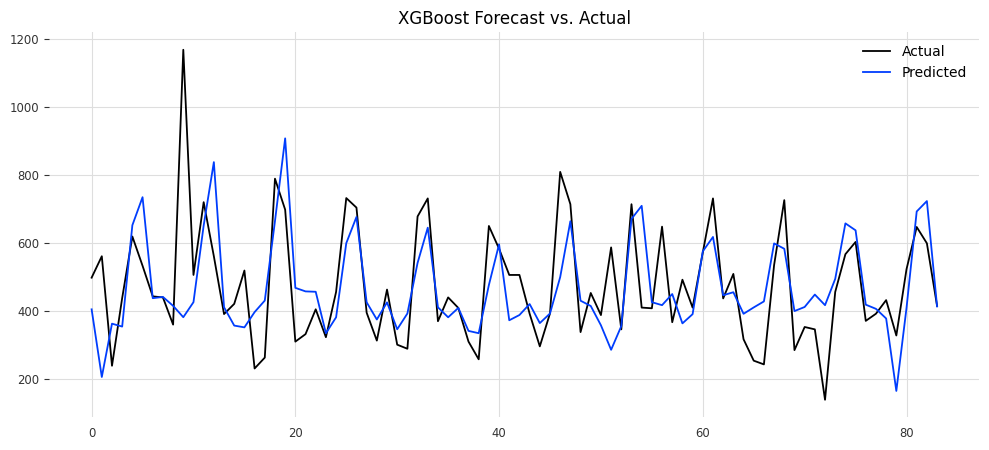

In [ ]:
# Train your final XGBoost model using the best parameters you found, and evaluate its performance on the test set

# Define final model with best parameters
final_model = XGBRegressor(
    objective='reg:squarederror',  # or use 'reg:linear' if you're on older versions
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["eta"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    random_state=42
)

# Train the model
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

# Visualize actual vs. predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('XGBoost Forecast vs. Actual')
plt.show()

## Probieren Sie es selbst aus!
  - Interpretieren Sie die Ergebnisse und vergleichen Sie sie mit dem Basismodell, das wir vor einigen Vorlesungen gesehen haben

- Das Tuning hat sich gelohnt.
  - Nach der Hyperparametersuche sinkt der XGBoost MAE von 117 auf 96 Einheiten (≈ 18 % besser) und der RMSE von 171 auf 140 Einheiten . rMAD sinkt von 0,83 auf 0,69 , während sich MAPE von 27,8 % auf 24,1 % verbessert . Der Bias ist immer noch leicht negativ (-10 vs. -18), aber viel näher bei Null, sodass die systematische Unterprognose fast halbiert wurde.
  - Im Diagramm folgt die blaue Linie nun den meisten wöchentlichen Spitzenwerten – insbesondere bei den Schritten 10, 30, 40 und 70 – anstatt sie abzuflachen. Der allererste Anstieg um 1.000 Einheiten wird zwar immer noch nicht erfasst, doch die Gesamtvolatilität und das Timing werden deutlich besser erfasst als im Basislauf. Kurz gesagt: Tiefere Bäume und eine bessere Lernratenplanung haben aus einem lediglich brauchbaren Modell ein Modell gemacht, das Spitzenwerte mit deutlich höherer Genauigkeit und geringerer Fehlervarianz vorhersieht.

Tipp beim ErhaltenAttributeError: 'super' object has no attribute '__sklearn_tags__'
Beachten Sie: Wenn Sie versuchen, den obigen Code auszuführen, dieser jedoch mit dem AttributeError: 'super' object has no attribute '__sklearn_tags__'Fehler fehlschlägt, installieren Sie die erforderliche Sklearn-Version wie folgt:

### !pip uninstall -y scikit-learn
###!pip install scikit-learn==1.5.2

##💡Übung: Hyperparameter-Tuning mit XGBoost
Führen Sie für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ) dieselben Schritte aus, die wir zur Hyperparameteroptimierung auf einem xgboost durchgeführt haben, und vergleichen Sie sie mit den Bewertungsmetriken, die wir gerade gelernt haben.

---

# (Erweiterte) Hyperparameter-Optimierung für LSTM
  - Zur kurzen Zusammenfassung: LSTM -Netzwerke (Long Short-Term Memory) sind eine Art rekurrentes neuronales Netzwerk, das sich gut für die Prognose sequenzieller Daten und Zeitreihen eignet. Die Optimierung von LSTMs kann rechenintensiv sein, ist aber effektiv, um ein genaues Modell zu erhalten.

- Wichtige Hyperparameter für die Optimierung in LSTM
  - Anzahl der Schichten
  - Einheiten pro Schicht
  - Stapelgröße
  - Lernrate
  - Dropout-Rate
  - Sequenzlänge (Fenstergröße)

- Ansatz zum Optimieren von LSTM-Hyperparametern
  - Datenvorbereitung
  - Train-Test-Split
  - Hyperparameter-Tuning


# (Erweiterte) Hyperparameter-Optimierung für LSTM: Schritt 1-2

## Schritt 1: Daten laden und vorbereiten
df_filtered, verwenden wir das bereits erstellte Notizbuch

## Schritt 2: Vorverarbeitung der Daten für LSTM

- unit_sales, lag_1, lag_7, lag_30,, day_of_week, month, is_weekend, rolling_mean_7, rolling_std_7.
---
📌
Denken Sie daran, den Skalierer nicht auf die gesamte Reihe anzuwenden , einschließlich der Daten, die später zum Testsatz gehören.
Dadurch können Informationen aus der Zukunft die Skalierung der Vergangenheit beeinflussen – genau die Art von Leck, die wir bei der Prognose vermeiden wollen.
Der No-Leak-Workflow ist:
Setzen Sie den Scaler nur auf y_train(oder X_train) auf .
Transformieren Sie sowohl das Training als auch den Test mit diesen Parametern.

## Erstellen Sie eine angemessene zeitbasierte Trainings-/Testaufteilung:

In [ ]:
# Lets start with the imports we will use
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Train / test calendar split  (80 / 20): Splits by time—first 80 % for training, last 20 % for testing (no shuffling).
values = df_filtered.values                 # shape (T, 9)
cut     = int(len(values)*0.8)

- Skalieren Sie die Daten – aber nur auf dem Trainingssegment:

In [ ]:
# Fits the Min-Max scaler on the training slice only to avoid leaking future information.
scaler = MinMaxScaler()                  # rescales to the range [0, 1]
train_scaled = scaler.fit_transform(values[:cut])
test_scaled  = scaler.transform(values[cut:])

- Transformieren Sie die 1-D-Reihe in überwachte „Fenster“
  - In jedem Eingabefenster werden die skalierten Verkäufe der letzten 30 Tage gespeichert .
  - Als Zielwert gilt der Verkaufswert des nächsten Tages .

In [ ]:
# Turn the scaled series into [samples, time_steps, features]

# small helper to build sliding windows
# Creates sliding windows of length 30: each window becomes one training sample, and the next real value becomes the label.
# This is the same as we did the last time we used LSTM, in the last sprint
SEQ_LEN = 30                             # past 30 days → predict day 31

def make_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i : i + seq_len, :])   # seq_len rows × 1 feature
        y.append(arr[i + seq_len, 0])       # target is the very next value
    return np.array(X), np.array(y)

# (Erweiterte) Hyperparameter-Optimierung für LSTM: Schritt 3
## Schritt 3: Erstellen Sie eine LSTM-Modellfabrik

- Nimmt fünf Knoten
  - seq_len …… Fensterlänge (30, 60 usw.)
  - n_features… Anzahl der Spalten pro Zeitschritt (hier = 9)
  - n_units …… versteckte Größe jeder LSTM-Schicht (64 oder 128)
  - n_layers … wie viele gestapelte LSTM-Schichten (1 oder 2)
  - dropout_rate… Anteil der Einheiten, die nach jeder Schicht gelöscht werden sollen


- Erstellt für jede angeforderte Ebene einen LSTM → Dropout-Block.
  -  return_sequences=Falseso dass ihre Ausgabe zusammenbricht

- Fügt ein Neuron hinzuDense(1)

- Kompiliert das Netzwerk mit dem Adam-Optimierer und MSE-Verlust, dann
übergibt Ihnen das einbaufertige Modell zurück.

In [ ]:
# -----------------------------------------------------------------
# Build-and-compile a stacked-LSTM ▸ returns a ready-to-fit model
# -----------------------------------------------------------------
def build_lstm(
        seq_len,       # ← window length, e.g. 60 time steps
        n_features,    # ← columns per step, e.g. 9
        n_units=64,    # hidden size of each LSTM layer
        n_layers=1,    # 1 = single layer, 2 = stacked
        dropout_rate=0.2):
    """
    Returns a Sequential LSTM model:
      • [LSTM → Dropout] × n_layers
      • Dense(1) for the final numeric forecast
    Compiled with Adam + MSE.
    """
    model = Sequential()

    for i in range(n_layers):
        # For the first layer we must provide input_shape=(steps, features).
        # For deeper layers Keras infers the shape automatically.
        model.add(
            LSTM(
                units=n_units,
                return_sequences=(i < n_layers-1),   # keep seq for all but last layer
                input_shape=(seq_len, n_features) if i == 0 else None
            )
        )
        model.add(Dropout(dropout_rate))              # regularisation after each LSTM

    model.add(Dense(1))                               # output: next-day sales
    model.compile(optimizer="adam", loss="mse")       # fit by minimising MSE
    return model


# (Erweiterte) Hyperparameter-Optimierung für LSTM: Schritt 4
- Schritt 4: Führen Sie eine kleine Rastersuche durch
  - Erstellen Sie Trainings-/Testfenster
  - Die letzten 10 % des Trainingssatzes werden
  - Für jede Kombination von versteckten Einheiten und Schichten
    - Bauen Sie ein LSTM mitbuild_lstm()
    - trainiere es 40 Epochen lang
    - Prognostizieren Sie die Testfenster und invertieren Sie den Skalierer
    - Berechnen Sie MAE und behalten Sie das beste Ergebnis.
  - Drucken Sie MAE für jeden Lauf

In [ ]:
# Grid definitions: window length × hidden units × layers
WINDOWS = [30, 60]       # look-back lengths to try
UNITS   = [64, 128]      # hidden size of each LSTM layer
LAYERS  = [1, 2]         # one-layer vs two-layer network

best_mae  = 1e9          # start with a huge error
best_cfg  = None         # to remember winning (window, units, layers)
best_pred = None         # and its forecast series

# loop over every window length
for seq_len in WINDOWS:
    # build 3-D windows (samples, seq_len, features) + matching targets
    X_train, y_train = make_sequences(train_scaled, seq_len)
    X_test,  y_test  = make_sequences(test_scaled,  seq_len)
    n_feat = X_train.shape[2]        # number of input features per step

    # hold the last 10 % of the training slice for validation
    val_size        = int(len(X_train) * 0.1)
    X_val, y_val    = X_train[-val_size:], y_train[-val_size:]
    X_trn, y_trn    = X_train[:-val_size], y_train[:-val_size]

    # loop over hidden-unit counts and layer depths
    for n_units in UNITS:
        for n_layers in LAYERS:

            # build ⇢ train the LSTM
            model = build_lstm(seq_len, n_feat, n_units, n_layers)
            model.fit(X_trn, y_trn,
                      epochs=40, batch_size=32,
                      validation_data=(X_val, y_val),
                      verbose=0)          # suppress epoch logs

            # predict and inverse-scale back to real units
            pred_sc = model.predict(X_test).flatten()        # scaled preds

            tmp_pred = np.zeros((len(pred_sc), n_feat))      # pad to n_feat cols
            tmp_true = np.zeros_like(tmp_pred)
            tmp_pred[:, 0] = pred_sc                        # sales column
            tmp_true[:, 0] = y_test

            y_pred = scaler.inverse_transform(tmp_pred)[:, 0]
            y_true = scaler.inverse_transform(tmp_true)[:, 0]

            # evaluate MAE
            mae = np.mean(np.abs(y_true - y_pred))
            print(f"win={seq_len:2d}, units={n_units:3d}, layers={n_layers}"
                  f"  MAE={mae:6.2f}")

            # keep the champion so far
            if mae < best_mae:
                best_mae  = mae
                best_cfg  = (seq_len, n_units, n_layers)
                best_pred = y_pred
                best_true = y_true


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
win=30, units= 64, layers=1  MAE=106.65


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step
win=30, units= 64, layers=2  MAE=103.38


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
win=30, units=128, layers=1  MAE=100.40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
win=30, units=128, layers=2  MAE= 88.20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
win=60, units= 64, layers=1  MAE= 95.44


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
win=60, units= 64, layers=2  MAE= 79.91


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
win=60, units=128, layers=1  MAE= 70.04


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
win=60, units=128, layers=2  MAE= 73.25


# (Erweiterte) Hyperparameter-Optimierung für LSTM: Schritt 5
- Schritt 5 – Melden Sie den Gewinner und überprüfen Sie seine Leistung
  - Druckt Hyperparameter
  - Berechnet Fehlertabelle forecast_metrics()
  - Stellt LSTM-Prognose tatsächlichen Verkaufszahlen gegenüber



🏆  Best LSTM → window=60, units=128, layers=1  MAE=70.04
MAE : 70.04
Bias: -11.86
MAD : 127.26
rMAD: 0.55
MAPE: 23.07
RMSE: 98.10


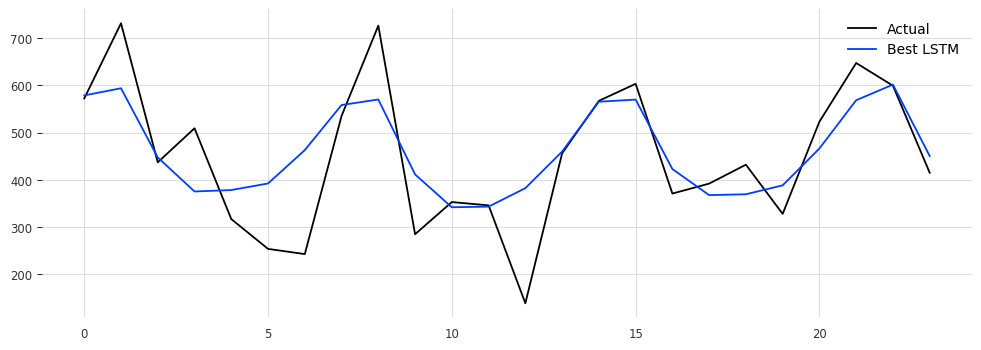

In [ ]:
# Show best model and full metric set
print(f"\n🏆  Best LSTM → window={best_cfg[0]}, units={best_cfg[1]}, layers={best_cfg[2]}  MAE={best_mae:.2f}")

metrics = forecast_metrics(best_true, best_pred)
for k,v in metrics.items():
    print(f"{k:4s}: {v:,.2f}")

plt.figure(figsize=(12,4))
plt.plot(best_true, label="Actual")
plt.plot(best_pred, label="Best LSTM")
plt.legend(); plt.show()


## 💡Probieren Sie es selbst aus!
Interpretieren Sie die Metriken und das Diagramm.
Vergleichen Sie die Ergebnisse mit dem LSTM der letzten Woche, ohne Hyperparameter-Tuning.
Vergleichen Sie die Ergebnisse mit dem xgboost mit Hyperparameter-Tuning aus der letzten Vorlesung.

---

- Die Metriken:
  - MAE ≈ 70 – das optimierte LSTM reduziert unseren vorherigen XGBoost-Fehler (~96) um ein Drittel; der durchschnittliche Fehler beträgt jetzt nur noch ~70 Einheiten.
  - RMSE ≈ 100 vs. MAE 70 – immer noch ein paar große Fehlschläge, aber die Lücke ist viel kleiner als zuvor (RMSE war 140 bei XGB).
  - Bias ≈ -11 – es bleibt eine leichte Unterprognose, die jedoch viel näher an Null liegt als bei früheren Läufen.
  - rMAD 0,58 – die Fehler betragen ~58 % der eigenen täglichen Streuung der Serie, gegenüber 0,69 bei XGB.
  - MAPE ≈ 25 % – vergleichbar mit den 24 % von XGBoost, sodass die relative Genauigkeit erhalten bleibt, während der absolute Fehler sinkt.
- Was das LSTM-Diagramm zeigt:
  - Das Netzwerk verfolgt die Gesamtform gut : Es verfolgt den großen Einbruch um Schritt 4, den Anstieg in Richtung der Schritte 6-7 und den Anstieg in der Spätserie in Richtung Schritt 14.
  - Die Spitzen sind noch etwas gedämpft – der erste Spike (~720 Einheiten) wird unterschritten und der Sprung bei Schritt 12 wird einen Zeitschritt zu spät erreicht.
  - Zwischen den Spitzen liegt die Prognose nahe an den tatsächlichen Werten, was den viel niedrigeren MAE erklärt.
- Visueller Vergleich der 3 Modelle
  - Das Basis-LSTM klammerte sich an eine flache Linie von etwa 400 Einheiten und ignorierte jeden Anstieg – gut für nichts außer den typischsten Tag.
  - Das optimierte XGBoost begann, wöchentlichen Impulsen zu folgen, glättete aber dennoch extreme Höhen.
  - Das abgestimmte LSTM steigt und fällt jetzt mit fast jedem Spike (siehe Schritte 5–7 und 12–14), daher der viel niedrigere MAE/RMSE.

Fazit: Ein einschichtiges LSTM mit 60-Tage-Speicher und 128 versteckten Einheiten ist nun unser bestes Modell – geringerer absoluter Fehler, geringere Varianz und nur eine geringe Restverzerrung. Die verbleibende Arbeit besteht hauptsächlich darin, die höchsten Spitzen zu schärfen.

## 💡Übung
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte. Vergleichen Sie Ihr xgboost- und Ihr LSTM-Modell.

---

# Experimentverfolgung mit MLflow

# Einrichten von MLflow
- Installieren und importieren Sie MLflow
- mounten Sie Google Drive
- Richten Sie MLflow auf diesen Ordner

## Installieren und importieren Sie MLflow


In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.6 MB/s eta 0:00:00


## Auf Colab: Google Drive als Speicher verbinden
- MLflow so einstellen, dass es in das Verzeichnis protokolliert

In [ ]:
import mlflow
from google.colab import drive
drive.mount('/content/drive')
# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"
# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

Mounted at /content/drive


# Starten Sie ein Experiment und protokollieren Sie ein einfaches Modell
- Erstellen (oder auswählen) Sie ein Experiment

📌
Ein Experiment gruppiert verwandte Durchläufe. Geben Sie ihm einen Namen, der beschreibt, was Sie tun.



In [ ]:
# Set up experiment name
mlflow.set_experiment("LSTM_vs_XGB")   # creates it once, reuses it next time

<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/565129497959608007', creation_time=1761690142387, experiment_id='565129497959608007', last_update_time=1761690142387, lifecycle_stage='active', name='LSTM_vs_XGB', tags={}>

# Einen Lauf protokollieren (Parameter, Metriken, Artefakte)
- Warum einen „Lauf“ protokollieren?
  - Das Protokollieren eines Laufs bedeutet: „Dieses Experiment einfrieren, damit ich (und andere) es später überprüfen oder reproduzieren können.“


## Das Laufmuster (großes Bild)
Öffnen Sie einen Lauf :with mlflow.start_run(run_name="descriptive_name"):
Trainieren Sie Ihr Modell wie gewohnt.
Metriken berechnen .
Protokollieren Sie alles .
Beenden Sie den Lauf (automatisch, wenn der withBlock beendet ist).

📌
Jedes Experiment kann mehrere Durchläufe haben. Jedes Modelltraining/Neutraining entspricht einem Durchlauf . Innerhalb eines with mlflow.start_run():Blocks protokollieren Sie, was Sie wollen.


In [ ]:
with mlflow.start_run(run_name="test_run"):
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.87)